Configuration

In [10]:
import os
from dotenv import load_dotenv

load_dotenv()

FOLDER_PATH = os.getenv("FOLDER_PATH")
files = [f"{FOLDER_PATH}_{i:02d}" for i in range(1, 51)]
OUTPUT_PATH = os.getenv("OUTPUT_PATH")

def jis_to_unicode(jis_code):
    # Rozbij kod 0x2422 → bajt1=0x24 , bajt2=0x22
    b1 = (jis_code >> 8) & 0xFF
    b2 = jis_code & 0xFF

    # JIS X 0208 w Pythonie wymaga konwersji przez ISO-2022-JP
    byte_seq = bytes([0x1B, 0x24, 0x42, b1, b2, 0x1B, 0x28, 0x42])

    return byte_seq.decode("iso2022_jp")

def unicode_to_jis(unicode_char):
    byte_seq = unicode_char.encode("iso2022_jp")
    if len(byte_seq) < 6:
        raise ValueError("Nieprawidłowy znak JIS")

    b1 = byte_seq[3]
    b2 = byte_seq[4]

    jis_code = (b1 << 8) | b2
    return jis_code

# selected_jis = [0x2422, 0x2424, 0x2426, 0x2428, 0x242A,
#                 0x242B, 0x242D, 0x242F, 0x2431, 0x2433,
#                 0x2435, 0x2437, 0x2439, 0x243B, 0x243D,
#                 0x243F, 0x2441, 0x2444, 0x2446, 0x2448,
#                 0x244A, 0x244B, 0x244C, 0x244D, 0x244E,
#                 0x244F, 0x2452, 0x2455, 0x2458, 0x245B,
#                 0x245E, 0x245F, 0x2460, 0x2461, 0x2462,
#                 0x2464, 0x2466, 0x2468,
#                 0x2469, 0x246A, 0x246B, 0x246C, 0x246D,
#                 0x246F, 0x2472, 0x2473,
#                 ]

selected_characters = ['あ', 'い', 'う', 'え', 'お',
                       'か', 'き', 'く', 'け', 'こ',
                       'さ', 'し', 'す', 'せ', 'そ',
                       'た', 'ち', 'つ', 'て', 'と',
                       'な', 'に', 'ぬ', 'ね', 'の',
                       'は', 'ひ', 'ふ', 'へ', 'ほ',
                       'ま', 'み', 'む', 'め', 'も',
                       'や', 'ゆ', 'よ',
                       'ら', 'り', 'る', 'れ', 'ろ',
                       'わ', 'を', 'ん',
                       ]

selected_jis = []
for char in selected_characters:
    jis_code = unicode_to_jis(char)
    selected_jis.append(jis_code)



Preprocess functions

In [11]:
import tensorflow as tf
from dataclasses import dataclass
import numpy as np
import cv2


@dataclass
class Record:
    """One record from a file ETL9G."""
    jis_code: int
    img: np.ndarray


def swap_white_and_black(img: np.ndarray) -> np.ndarray:
    """
    Swaps white and black pixels in the image.
    """
    return 15 - img


def clean_image_background(img: np.ndarray) -> np.ndarray:
    """
    Removes unwanted objects that touch the edges of the image.
    This helps eliminate neighboring fragments that result from scanning multiple samples from one sheet.
    Uses bfs to find connected components touching the edges and removes them.
    """
    # TODO: remove small objects inside the image
    # TOOD: check y and x order
    h, w = img.shape
    visited = np.zeros((h, w), dtype=bool)

    def bfs(start_x: int, start_y: int):
        queue = [(start_x, start_y)]
        while queue:
            x, y = queue.pop(0)
            if visited[x, y]:
                continue
            visited[x, y] = True
            if img[x, y] > 0:
                img[x, y] = 0
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < h and 0 <= ny < w and not visited[nx, ny]:
                        queue.append((nx, ny))

    for i in range(h):
        if not visited[i, 0]:
            bfs(i, 0)
        if not visited[i, w - 1]:
            bfs(i, w - 1)
    for i in range(w):
        if not visited[0, i]:
            bfs(0, i)
        if not visited[h - 1, i]:
            bfs(h - 1, i)

    return img


def cut_center_and_scale(img: np.ndarray, add_margin: bool = False) -> np.ndarray:
    """
    Cuts the center of the image and scales it to a fixed size.
    """
    mask = img > 1
    coords = np.argwhere(mask)

    if coords.size == 0:
        return img
    
    # TODO: check if +1 is needed
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1  # slices are exclusive at the top and bottom
    cropped_img = img[y0:y1, x0:x1]
    ch, cw = cropped_img.shape
    if add_margin:
        cropped_img = np.pad(cropped_img, pad_width=2, mode='constant', constant_values=0)

    scale = min(127 / ch, 128 / cw)
    new_h = int(ch * scale)
    new_w = int(cw * scale)

    scaled_img = tf.image.resize(
        cropped_img[..., np.newaxis],
        (new_h, new_w), method='bilinear'
    ).numpy()
    
    canvas = np.zeros((127, 128, 1), dtype=scaled_img.dtype)

    y_offset = (127 - new_h) // 2
    x_offset = (128 - new_w) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w, :] = scaled_img

    return canvas.astype(np.uint8).squeeze()


def convert_to_binary_image(img: np.ndarray, threshold = 3) -> np.ndarray:
    """
    Converts grayscale image to binary (black and white) image using thresholding.
    """
    binary_img = np.where(img > threshold, 15, 0).astype(np.uint8)
    return binary_img


def smooth_edges(img: np.ndarray, kernel_size: int = 7) -> np.ndarray:
    """
    Smooths the edges of the image using Gaussian blur.
    """
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return img


def thin_lines(img: np.ndarray, kernel_size: int = 2) -> np.ndarray:
    """
    Thins the lines in the image using morphological operations.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 209ms/step - accuracy: 0.3774 - loss: 2.4792 - val_accuracy: 0.7717 - val_loss: 0.8398
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 47s 206ms/step - accuracy: 0.6701 - loss: 1.2210 - val_accuracy: 0.8516 - val_loss: 0.5707
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 48s 208ms/step - accuracy: 0.7495 - loss: 0.9288 - val_accuracy: 0.8739 - val_loss: 0.4730
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 50s 217ms/step - accuracy: 0.7916 - loss: 0.7696 - val_accuracy: 0.8875 - val_loss: 0.4167
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 52s 224ms/step - accuracy: 0.8167 - loss: 0.6319 - val_accuracy: 0.8935 - val_loss: 0.3953
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 49s 211ms/step - accuracy: 0.8433 - loss: 0.5580 - val_accuracy: 0.8918 - val_loss: 0.3844
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 47s 206ms/step - accuracy: 0.8548 - loss: 0.5140 - val_accuracy: 0.9103 - val_loss: 0.3335
Epoch 8/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 47s 205ms/step - accuracy: 0.8625 - loss: 0

INFO:tensorflow:Assets written to: D:\Studia\Semestr 6\Projekt dyplomowy\repo\models\models/cnn_etl9g_$46s_50e_nomargin_smooth_simple\assets


Saved artifact at 'D:\Studia\Semestr 6\Projekt dyplomowy\repo\models\models/cnn_etl9g_$46s_50e_nomargin_smooth_simple'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 127, 128, 1), dtype=tf.float32, name='keras_tensor_70')
Output Type:
  TensorSpec(shape=(None, 46), dtype=tf.float32, name=None)
Captures:
  2042208416016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042208412752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042208412560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2040386133968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042208411216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042208411408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2040386128784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2040386133584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2040386132048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2040386132816: T

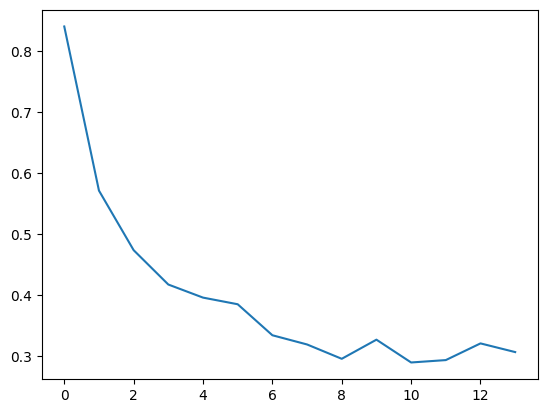

In [ ]:

from typing import BinaryIO, List, Optional
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
import struct
import numpy as np
import cv2
import matplotlib.pyplot as plt

@dataclass
class Record:
    """One record from a file ETL9G."""
    jis_code: int
    img: np.ndarray

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


def read_etl9g_records_from_file(f: BinaryIO) -> Optional[Record]:
    """
    Reads one record from a file ETL9G.
    Returns: (jis_code, img)
    """
    s = f.read(8199)
    if not s:
        return None
    r = struct.unpack('>HH8sIBBBBHHHHBB34s8128s7x', s)
    jis_code = r[1]
    img_bytes = r[15]
    
    arr = np.frombuffer(img_bytes, dtype = np.uint8)
    high = arr >> 4
    low = arr & 0x0F
    pixels = np.empty(arr.size * 2, dtype = np.uint8)
    pixels[0::2] = high
    pixels[1::2] = low
    img = pixels.reshape(127, 128)

    return Record(jis_code, img)


def read_etl9g_all_records() -> List[Record]:
    """
    Reads multiple files ETL9G binary
    """
    records = []
    for file in files:
        with open(file, "rb") as f:
            while True:
                record = read_etl9g_records_from_file(f)
                if record == None:
                    break
                if record.jis_code in selected_jis:
                    img = record.img
                    
                    simple_record = Record(record.jis_code, simple_preprocess(img))
                    records.append(simple_record)

                    # strong_record = Record(record.jis_code, preprocess(img))
                    # records.append(strong_record)

    return records


def simple_preprocess(img: np.ndarray) -> np.ndarray:
    """
    Simple preprocessing steps.
    """
    img = clean_image_background(img)
    img = cut_center_and_scale(img)
    # img = smooth_edges(img)
    img = convert_to_binary_image(img)
    img = swap_white_and_black(img)
    return img

def preprocess(img: np.ndarray) -> np.ndarray:
    """
    Repeated preprocessing steps to get the best result.
    """
    img = thin_lines(img, kernel_size=2)
    img = clean_image_background(img)
    img = cut_center_and_scale(img)
    img = smooth_edges(img)
    img = convert_to_binary_image(img, 3)
    img = cut_center_and_scale(img, add_margin=True)
    img = smooth_edges(img)
    img = convert_to_binary_image(img, 6)
    img = swap_white_and_black(img)
    return img


def create_cnn(with_augmentation=True):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(127, 128, 1)))

    if with_augmentation:
        model.add(tf.keras.Sequential([
            layers.RandomRotation(0.1),
            layers.RandomZoom(height_factor=(-0.1, 0.0), width_factor=(-0.1, 0.0)),
            # layers.RandomTranslation(0.1, 0.1),   # not needed because images are centered
            # layers.RandomFlip("horizontal")       # shouldn't be used for writing
        ]))

    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(selected_jis), activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def split_data(records: List[Record]) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Splits the data into training and testing sets.
    """
    images = np.array([record.img for record in records])
    labels = np.array([selected_jis.index(record.jis_code) for record in records])

    images = images[..., np.newaxis]  # add channel dimension

    images_train, images_test, labels_train, labels_test = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )

    return images_train, images_test, labels_train, labels_test


def save_model(model: tf.keras.Model, path: str):
    """
    Saves the model to the specified path.
    """
    model.export(path)
    converter = tf.lite.TFLiteConverter.from_saved_model(path)
    tflite_model = converter.convert()
    with open(f"{path}.tflite", "wb") as f:
        f.write(tflite_model)


if __name__ == "__main__":
    records = read_etl9g_all_records()
    images_train, images_test, labels_train, labels_test = split_data(records)

    model = create_cnn(with_augmentation=True)
    # TODO: check if summary needed
    # model.summary()
    history = model.fit(
        images_train, labels_train,
        validation_data=(images_test, labels_test),
        epochs=50,
        shuffle=True,
        callbacks=[early_stop]
    )
    plt.plot(history.history['val_loss'])

    model_no_augmentation = create_cnn(with_augmentation=False)
    model_no_augmentation.set_weights(model.get_weights())
    save_model(model_no_augmentation, f"{OUTPUT_PATH}/cnn_etl9g_{len(selected_jis)}s_50e_nomargin_smooth_simple")

